In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import eikon as ek
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import os
from PIL import Image
import mplfinance as mpf

In [2]:
# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# Check the current CUDA device
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA device detected.")

CUDA Available: True
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 3080


In [3]:
!nvidia-smi

Mon Nov 18 20:06:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  |   00000000:01:00.0  On |                  N/A |
| 53%   42C    P8             39W /  320W |    7079MiB /  10240MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
ek.set_app_key('7001d23cf74b4dd3a4ba3ed95bba9d29fb71e7ff')

In [5]:
config = {
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "red",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 5,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda",
        "batch_size": 64,
        "num_epoch": 10000,
        "learning_rate": 0.005,
        "scheduler_step_size": 10000,
    }
}

In [6]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=4, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.relu = torch.nn.ReLU()
        self.lstm = torch.nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear_2 = torch.nn.Linear(num_layers*hidden_layer_size, output_size)
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 torch.nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 torch.nn.init.kaiming_normal_(param)
            #elif 'weight_hh' in name:
            #     torch.nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [7]:
data = ek.get_timeseries('XOM',
                        fields = '*', 
                        start_date = '2012-03-31',
                        end_date= '2024-3-31')
data_date = [i.date().isoformat() for i in data["CLOSE"].index.tolist()]

In [8]:
data_close_price = np.array(data['CLOSE'])
data_close_price

array([ 86.07,  86.08,  86.34, ..., 113.79, 114.97, 116.24])

In [9]:
num_data_points = len(data_close_price)
train_split_size = 0.8

In [10]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0, keepdims = True)
        self.sd = np.std(x, axis=0, keepdims = True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

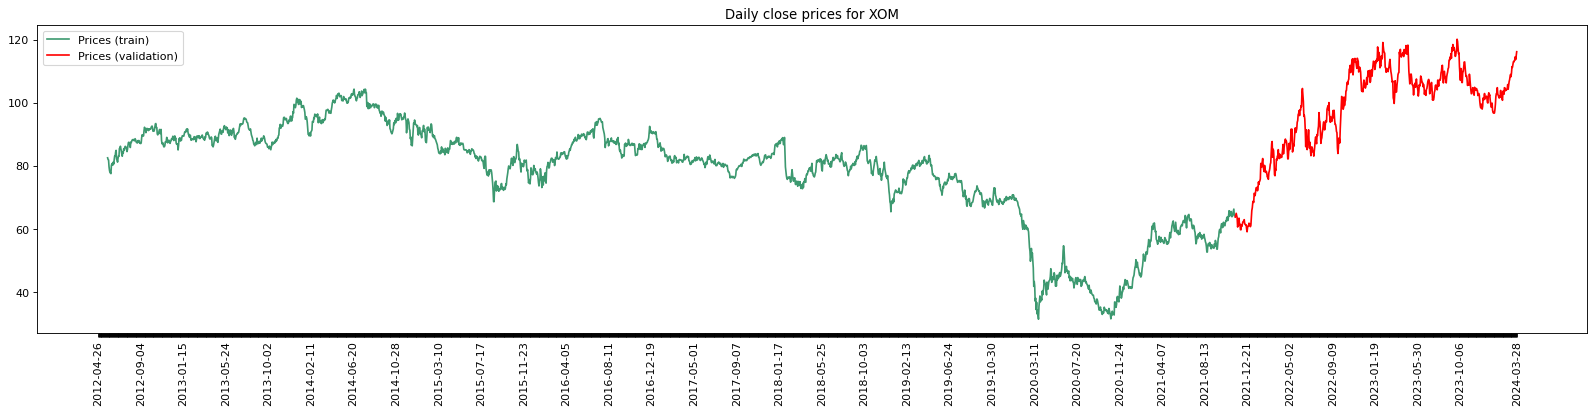

In [11]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*train_split_size)
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + data.columns.name )
        plt.legend()
        plt.show()
        fig.savefig("XOM_close_plot.png", dpi=300, bbox_inches='tight')

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot = True)

In [12]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (2384, 20, 1) (2384,)
Validation data shape (596, 20, 1) (596,)


In [13]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/10000] | loss train:0.053319, test:0.015210 | lr:0.005000
Epoch[2/10000] | loss train:0.009597, test:0.016822 | lr:0.005000
Epoch[3/10000] | loss train:0.007954, test:0.009981 | lr:0.005000
Epoch[4/10000] | loss train:0.006529, test:0.005754 | lr:0.005000
Epoch[5/10000] | loss train:0.005518, test:0.007592 | lr:0.005000
Epoch[6/10000] | loss train:0.005508, test:0.007483 | lr:0.005000
Epoch[7/10000] | loss train:0.005268, test:0.006533 | lr:0.005000
Epoch[8/10000] | loss train:0.005155, test:0.011300 | lr:0.005000
Epoch[9/10000] | loss train:0.005368, test:0.008753 | lr:0.005000
Epoch[10/10000] | loss train:0.005218, test:0.005087 | lr:0.005000
Epoch[11/10000] | loss train:0.007031, test:0.004945 | lr:0.005000
Epoch[12/10000] | loss train:0.004925, test:0.007256 | lr:0.005000
Epoch[13/10000] | loss train:0.003947, test:0.005180 | lr:0.005000
Epoch[14/10000] | loss train:0.006000, test:0.004195 | lr:0.005000
Epoch[15/10000] | loss train:0.004303, test:0.009811 | lr:0.005000
Epoc

Epoch[1690/10000] | loss train:0.002008, test:0.002111 | lr:0.005000
Epoch[1691/10000] | loss train:0.001985, test:0.001998 | lr:0.005000
Epoch[1692/10000] | loss train:0.001916, test:0.002430 | lr:0.005000
Epoch[1693/10000] | loss train:0.001881, test:0.002253 | lr:0.005000
Epoch[1694/10000] | loss train:0.002013, test:0.002509 | lr:0.005000
Epoch[1695/10000] | loss train:0.002023, test:0.002779 | lr:0.005000
Epoch[1696/10000] | loss train:0.002349, test:0.001985 | lr:0.005000
Epoch[1697/10000] | loss train:0.002082, test:0.002193 | lr:0.005000
Epoch[1698/10000] | loss train:0.002083, test:0.002597 | lr:0.005000
Epoch[1699/10000] | loss train:0.002279, test:0.002089 | lr:0.005000
Epoch[1700/10000] | loss train:0.001829, test:0.002409 | lr:0.005000
Epoch[1701/10000] | loss train:0.001972, test:0.002305 | lr:0.005000
Epoch[1702/10000] | loss train:0.001961, test:0.002127 | lr:0.005000
Epoch[1703/10000] | loss train:0.002169, test:0.001917 | lr:0.005000
Epoch[1704/10000] | loss train:0.0

Epoch[1809/10000] | loss train:0.002051, test:0.001934 | lr:0.005000
Epoch[1810/10000] | loss train:0.001981, test:0.002058 | lr:0.005000
Epoch[1811/10000] | loss train:0.001964, test:0.002318 | lr:0.005000
Epoch[1812/10000] | loss train:0.001682, test:0.002109 | lr:0.005000
Epoch[1813/10000] | loss train:0.002067, test:0.002000 | lr:0.005000
Epoch[1814/10000] | loss train:0.002122, test:0.002089 | lr:0.005000
Epoch[1815/10000] | loss train:0.002248, test:0.002615 | lr:0.005000
Epoch[1816/10000] | loss train:0.002028, test:0.001997 | lr:0.005000
Epoch[1817/10000] | loss train:0.001794, test:0.003320 | lr:0.005000
Epoch[1818/10000] | loss train:0.001864, test:0.002306 | lr:0.005000
Epoch[1819/10000] | loss train:0.001810, test:0.002312 | lr:0.005000
Epoch[1820/10000] | loss train:0.001834, test:0.002026 | lr:0.005000
Epoch[1821/10000] | loss train:0.001735, test:0.001918 | lr:0.005000
Epoch[1822/10000] | loss train:0.001785, test:0.002397 | lr:0.005000
Epoch[1823/10000] | loss train:0.0

Epoch[1928/10000] | loss train:0.001700, test:0.002345 | lr:0.005000
Epoch[1929/10000] | loss train:0.001873, test:0.002038 | lr:0.005000
Epoch[1930/10000] | loss train:0.001808, test:0.002000 | lr:0.005000
Epoch[1931/10000] | loss train:0.001863, test:0.002092 | lr:0.005000
Epoch[1932/10000] | loss train:0.001519, test:0.002996 | lr:0.005000
Epoch[1933/10000] | loss train:0.001621, test:0.001914 | lr:0.005000
Epoch[1934/10000] | loss train:0.001783, test:0.002073 | lr:0.005000
Epoch[1935/10000] | loss train:0.001690, test:0.002380 | lr:0.005000
Epoch[1936/10000] | loss train:0.001673, test:0.002100 | lr:0.005000
Epoch[1937/10000] | loss train:0.001758, test:0.002401 | lr:0.005000
Epoch[1938/10000] | loss train:0.001721, test:0.002066 | lr:0.005000
Epoch[1939/10000] | loss train:0.001772, test:0.002057 | lr:0.005000
Epoch[1940/10000] | loss train:0.001943, test:0.002613 | lr:0.005000
Epoch[1941/10000] | loss train:0.001772, test:0.002383 | lr:0.005000
Epoch[1942/10000] | loss train:0.0

Epoch[2048/10000] | loss train:0.001639, test:0.002569 | lr:0.005000
Epoch[2049/10000] | loss train:0.001969, test:0.002148 | lr:0.005000
Epoch[2050/10000] | loss train:0.001730, test:0.002235 | lr:0.005000
Epoch[2051/10000] | loss train:0.001914, test:0.002199 | lr:0.005000
Epoch[2052/10000] | loss train:0.001575, test:0.002420 | lr:0.005000
Epoch[2053/10000] | loss train:0.001813, test:0.002154 | lr:0.005000
Epoch[2054/10000] | loss train:0.001699, test:0.002381 | lr:0.005000
Epoch[2055/10000] | loss train:0.001624, test:0.002155 | lr:0.005000
Epoch[2056/10000] | loss train:0.001822, test:0.002926 | lr:0.005000
Epoch[2057/10000] | loss train:0.002131, test:0.002141 | lr:0.005000
Epoch[2058/10000] | loss train:0.001670, test:0.002181 | lr:0.005000
Epoch[2059/10000] | loss train:0.001971, test:0.002604 | lr:0.005000
Epoch[2060/10000] | loss train:0.001657, test:0.002290 | lr:0.005000
Epoch[2061/10000] | loss train:0.001480, test:0.002492 | lr:0.005000
Epoch[2062/10000] | loss train:0.0

Epoch[2167/10000] | loss train:0.001853, test:0.002084 | lr:0.005000
Epoch[2168/10000] | loss train:0.001848, test:0.002126 | lr:0.005000
Epoch[2169/10000] | loss train:0.001639, test:0.002460 | lr:0.005000
Epoch[2170/10000] | loss train:0.001682, test:0.002417 | lr:0.005000
Epoch[2171/10000] | loss train:0.001630, test:0.002346 | lr:0.005000
Epoch[2172/10000] | loss train:0.001595, test:0.002187 | lr:0.005000
Epoch[2173/10000] | loss train:0.001554, test:0.001997 | lr:0.005000
Epoch[2174/10000] | loss train:0.001806, test:0.002589 | lr:0.005000
Epoch[2175/10000] | loss train:0.001879, test:0.002004 | lr:0.005000
Epoch[2176/10000] | loss train:0.001654, test:0.002317 | lr:0.005000
Epoch[2177/10000] | loss train:0.001674, test:0.001959 | lr:0.005000
Epoch[2178/10000] | loss train:0.001964, test:0.002706 | lr:0.005000
Epoch[2179/10000] | loss train:0.001633, test:0.002818 | lr:0.005000
Epoch[2180/10000] | loss train:0.001530, test:0.002397 | lr:0.005000
Epoch[2181/10000] | loss train:0.0

Epoch[2286/10000] | loss train:0.001572, test:0.003175 | lr:0.005000
Epoch[2287/10000] | loss train:0.001717, test:0.002682 | lr:0.005000
Epoch[2288/10000] | loss train:0.001665, test:0.002015 | lr:0.005000
Epoch[2289/10000] | loss train:0.001497, test:0.002367 | lr:0.005000
Epoch[2290/10000] | loss train:0.001433, test:0.002105 | lr:0.005000
Epoch[2291/10000] | loss train:0.001572, test:0.001985 | lr:0.005000
Epoch[2292/10000] | loss train:0.001617, test:0.001850 | lr:0.005000
Epoch[2293/10000] | loss train:0.001785, test:0.002259 | lr:0.005000
Epoch[2294/10000] | loss train:0.001692, test:0.001958 | lr:0.005000
Epoch[2295/10000] | loss train:0.001496, test:0.002079 | lr:0.005000
Epoch[2296/10000] | loss train:0.001774, test:0.002904 | lr:0.005000
Epoch[2297/10000] | loss train:0.001893, test:0.002448 | lr:0.005000
Epoch[2298/10000] | loss train:0.001583, test:0.002048 | lr:0.005000
Epoch[2299/10000] | loss train:0.001607, test:0.002179 | lr:0.005000
Epoch[2300/10000] | loss train:0.0

Epoch[2405/10000] | loss train:0.001573, test:0.001876 | lr:0.005000
Epoch[2406/10000] | loss train:0.001365, test:0.002371 | lr:0.005000
Epoch[2407/10000] | loss train:0.001581, test:0.002216 | lr:0.005000
Epoch[2408/10000] | loss train:0.001601, test:0.002034 | lr:0.005000
Epoch[2409/10000] | loss train:0.001543, test:0.002203 | lr:0.005000
Epoch[2410/10000] | loss train:0.001748, test:0.002237 | lr:0.005000
Epoch[2411/10000] | loss train:0.001508, test:0.002228 | lr:0.005000
Epoch[2412/10000] | loss train:0.001491, test:0.002206 | lr:0.005000
Epoch[2413/10000] | loss train:0.001665, test:0.002069 | lr:0.005000
Epoch[2414/10000] | loss train:0.001521, test:0.002010 | lr:0.005000
Epoch[2415/10000] | loss train:0.001487, test:0.002253 | lr:0.005000
Epoch[2416/10000] | loss train:0.001583, test:0.002021 | lr:0.005000
Epoch[2417/10000] | loss train:0.001458, test:0.002129 | lr:0.005000
Epoch[2418/10000] | loss train:0.001568, test:0.002154 | lr:0.005000
Epoch[2419/10000] | loss train:0.0

Epoch[2525/10000] | loss train:0.001420, test:0.001978 | lr:0.005000
Epoch[2526/10000] | loss train:0.001458, test:0.002228 | lr:0.005000
Epoch[2527/10000] | loss train:0.001572, test:0.002352 | lr:0.005000
Epoch[2528/10000] | loss train:0.001415, test:0.002330 | lr:0.005000
Epoch[2529/10000] | loss train:0.001552, test:0.002406 | lr:0.005000
Epoch[2530/10000] | loss train:0.001453, test:0.002009 | lr:0.005000
Epoch[2531/10000] | loss train:0.001709, test:0.002181 | lr:0.005000
Epoch[2532/10000] | loss train:0.001439, test:0.002190 | lr:0.005000
Epoch[2533/10000] | loss train:0.001472, test:0.002495 | lr:0.005000
Epoch[2534/10000] | loss train:0.001385, test:0.002249 | lr:0.005000
Epoch[2535/10000] | loss train:0.001405, test:0.002148 | lr:0.005000
Epoch[2536/10000] | loss train:0.001594, test:0.002379 | lr:0.005000
Epoch[2537/10000] | loss train:0.001386, test:0.001915 | lr:0.005000
Epoch[2538/10000] | loss train:0.001473, test:0.002004 | lr:0.005000
Epoch[2539/10000] | loss train:0.0

Epoch[2644/10000] | loss train:0.001278, test:0.002062 | lr:0.005000
Epoch[2645/10000] | loss train:0.001654, test:0.001991 | lr:0.005000
Epoch[2646/10000] | loss train:0.001425, test:0.002366 | lr:0.005000
Epoch[2647/10000] | loss train:0.001309, test:0.002090 | lr:0.005000
Epoch[2648/10000] | loss train:0.001413, test:0.002081 | lr:0.005000
Epoch[2649/10000] | loss train:0.001377, test:0.002083 | lr:0.005000
Epoch[2650/10000] | loss train:0.001534, test:0.002172 | lr:0.005000
Epoch[2651/10000] | loss train:0.001427, test:0.002277 | lr:0.005000
Epoch[2652/10000] | loss train:0.001394, test:0.002278 | lr:0.005000
Epoch[2653/10000] | loss train:0.001318, test:0.002418 | lr:0.005000
Epoch[2654/10000] | loss train:0.001598, test:0.002205 | lr:0.005000
Epoch[2655/10000] | loss train:0.001382, test:0.002106 | lr:0.005000
Epoch[2656/10000] | loss train:0.001673, test:0.002312 | lr:0.005000
Epoch[2657/10000] | loss train:0.001589, test:0.002061 | lr:0.005000
Epoch[2658/10000] | loss train:0.0

Epoch[2763/10000] | loss train:0.001298, test:0.002039 | lr:0.005000
Epoch[2764/10000] | loss train:0.001573, test:0.002282 | lr:0.005000
Epoch[2765/10000] | loss train:0.001335, test:0.002150 | lr:0.005000
Epoch[2766/10000] | loss train:0.001363, test:0.001955 | lr:0.005000
Epoch[2767/10000] | loss train:0.001467, test:0.002196 | lr:0.005000
Epoch[2768/10000] | loss train:0.001512, test:0.002093 | lr:0.005000
Epoch[2769/10000] | loss train:0.001276, test:0.002192 | lr:0.005000
Epoch[2770/10000] | loss train:0.001424, test:0.002178 | lr:0.005000
Epoch[2771/10000] | loss train:0.001256, test:0.002130 | lr:0.005000
Epoch[2772/10000] | loss train:0.001399, test:0.002498 | lr:0.005000
Epoch[2773/10000] | loss train:0.001359, test:0.003499 | lr:0.005000
Epoch[2774/10000] | loss train:0.001465, test:0.002598 | lr:0.005000
Epoch[2775/10000] | loss train:0.001512, test:0.002371 | lr:0.005000
Epoch[2776/10000] | loss train:0.001493, test:0.002213 | lr:0.005000
Epoch[2777/10000] | loss train:0.0

Epoch[2882/10000] | loss train:0.001549, test:0.002282 | lr:0.005000
Epoch[2883/10000] | loss train:0.001412, test:0.002356 | lr:0.005000
Epoch[2884/10000] | loss train:0.001524, test:0.002396 | lr:0.005000
Epoch[2885/10000] | loss train:0.001369, test:0.002223 | lr:0.005000
Epoch[2886/10000] | loss train:0.001236, test:0.002053 | lr:0.005000
Epoch[2887/10000] | loss train:0.001560, test:0.002269 | lr:0.005000
Epoch[2888/10000] | loss train:0.001552, test:0.001913 | lr:0.005000
Epoch[2889/10000] | loss train:0.001504, test:0.002314 | lr:0.005000
Epoch[2890/10000] | loss train:0.001301, test:0.002332 | lr:0.005000
Epoch[2891/10000] | loss train:0.001410, test:0.002542 | lr:0.005000
Epoch[2892/10000] | loss train:0.001412, test:0.002216 | lr:0.005000
Epoch[2893/10000] | loss train:0.001374, test:0.002502 | lr:0.005000
Epoch[2894/10000] | loss train:0.001407, test:0.002663 | lr:0.005000
Epoch[2895/10000] | loss train:0.001306, test:0.002209 | lr:0.005000
Epoch[2896/10000] | loss train:0.0

Epoch[3002/10000] | loss train:0.001288, test:0.001841 | lr:0.005000
Epoch[3003/10000] | loss train:0.001294, test:0.002286 | lr:0.005000
Epoch[3004/10000] | loss train:0.001291, test:0.002047 | lr:0.005000
Epoch[3005/10000] | loss train:0.001347, test:0.003642 | lr:0.005000
Epoch[3006/10000] | loss train:0.001267, test:0.003113 | lr:0.005000
Epoch[3007/10000] | loss train:0.001382, test:0.002443 | lr:0.005000
Epoch[3008/10000] | loss train:0.001492, test:0.002324 | lr:0.005000
Epoch[3009/10000] | loss train:0.001411, test:0.002473 | lr:0.005000
Epoch[3010/10000] | loss train:0.001260, test:0.002309 | lr:0.005000
Epoch[3011/10000] | loss train:0.001404, test:0.002209 | lr:0.005000
Epoch[3012/10000] | loss train:0.001357, test:0.002020 | lr:0.005000
Epoch[3013/10000] | loss train:0.001373, test:0.001857 | lr:0.005000
Epoch[3014/10000] | loss train:0.001283, test:0.002316 | lr:0.005000
Epoch[3015/10000] | loss train:0.001496, test:0.002332 | lr:0.005000
Epoch[3016/10000] | loss train:0.0

Epoch[3121/10000] | loss train:0.001242, test:0.002836 | lr:0.005000
Epoch[3122/10000] | loss train:0.001208, test:0.002090 | lr:0.005000
Epoch[3123/10000] | loss train:0.001364, test:0.002039 | lr:0.005000
Epoch[3124/10000] | loss train:0.001270, test:0.002256 | lr:0.005000
Epoch[3125/10000] | loss train:0.001309, test:0.002225 | lr:0.005000
Epoch[3126/10000] | loss train:0.001373, test:0.002172 | lr:0.005000
Epoch[3127/10000] | loss train:0.001376, test:0.002082 | lr:0.005000
Epoch[3128/10000] | loss train:0.001311, test:0.002009 | lr:0.005000
Epoch[3129/10000] | loss train:0.001402, test:0.002374 | lr:0.005000
Epoch[3130/10000] | loss train:0.001435, test:0.002014 | lr:0.005000
Epoch[3131/10000] | loss train:0.001315, test:0.002355 | lr:0.005000
Epoch[3132/10000] | loss train:0.001331, test:0.001960 | lr:0.005000
Epoch[3133/10000] | loss train:0.001247, test:0.001855 | lr:0.005000
Epoch[3134/10000] | loss train:0.001269, test:0.002220 | lr:0.005000
Epoch[3135/10000] | loss train:0.0

Epoch[3240/10000] | loss train:0.001311, test:0.002043 | lr:0.005000
Epoch[3241/10000] | loss train:0.001322, test:0.002080 | lr:0.005000
Epoch[3242/10000] | loss train:0.001465, test:0.003337 | lr:0.005000
Epoch[3243/10000] | loss train:0.001345, test:0.002225 | lr:0.005000
Epoch[3244/10000] | loss train:0.001219, test:0.001961 | lr:0.005000
Epoch[3245/10000] | loss train:0.001315, test:0.001856 | lr:0.005000
Epoch[3246/10000] | loss train:0.001390, test:0.002165 | lr:0.005000
Epoch[3247/10000] | loss train:0.001775, test:0.002294 | lr:0.005000
Epoch[3248/10000] | loss train:0.001516, test:0.002867 | lr:0.005000
Epoch[3249/10000] | loss train:0.001352, test:0.001811 | lr:0.005000
Epoch[3250/10000] | loss train:0.001305, test:0.001908 | lr:0.005000
Epoch[3251/10000] | loss train:0.001374, test:0.001914 | lr:0.005000
Epoch[3252/10000] | loss train:0.001232, test:0.002504 | lr:0.005000
Epoch[3253/10000] | loss train:0.001404, test:0.002233 | lr:0.005000
Epoch[3254/10000] | loss train:0.0

Epoch[3359/10000] | loss train:0.001288, test:0.002059 | lr:0.005000
Epoch[3360/10000] | loss train:0.001413, test:0.001937 | lr:0.005000
Epoch[3361/10000] | loss train:0.001225, test:0.003855 | lr:0.005000
Epoch[3362/10000] | loss train:0.001337, test:0.002010 | lr:0.005000
Epoch[3363/10000] | loss train:0.001230, test:0.001772 | lr:0.005000
Epoch[3364/10000] | loss train:0.001389, test:0.002348 | lr:0.005000
Epoch[3365/10000] | loss train:0.001258, test:0.002099 | lr:0.005000
Epoch[3366/10000] | loss train:0.001547, test:0.002214 | lr:0.005000
Epoch[3367/10000] | loss train:0.001231, test:0.002059 | lr:0.005000
Epoch[3368/10000] | loss train:0.001469, test:0.001851 | lr:0.005000
Epoch[3369/10000] | loss train:0.001266, test:0.002126 | lr:0.005000
Epoch[3370/10000] | loss train:0.001445, test:0.002258 | lr:0.005000
Epoch[3371/10000] | loss train:0.001576, test:0.002163 | lr:0.005000
Epoch[3372/10000] | loss train:0.001334, test:0.002120 | lr:0.005000
Epoch[3373/10000] | loss train:0.0

Epoch[3478/10000] | loss train:0.001368, test:0.002019 | lr:0.005000
Epoch[3479/10000] | loss train:0.001117, test:0.002057 | lr:0.005000
Epoch[3480/10000] | loss train:0.001260, test:0.002250 | lr:0.005000
Epoch[3481/10000] | loss train:0.001423, test:0.001698 | lr:0.005000
Epoch[3482/10000] | loss train:0.001287, test:0.002170 | lr:0.005000
Epoch[3483/10000] | loss train:0.001325, test:0.001960 | lr:0.005000
Epoch[3484/10000] | loss train:0.001314, test:0.001869 | lr:0.005000
Epoch[3485/10000] | loss train:0.001253, test:0.002032 | lr:0.005000
Epoch[3486/10000] | loss train:0.001120, test:0.002033 | lr:0.005000
Epoch[3487/10000] | loss train:0.001125, test:0.002002 | lr:0.005000
Epoch[3488/10000] | loss train:0.001264, test:0.002097 | lr:0.005000
Epoch[3489/10000] | loss train:0.001383, test:0.001915 | lr:0.005000
Epoch[3490/10000] | loss train:0.001559, test:0.002345 | lr:0.005000
Epoch[3491/10000] | loss train:0.001410, test:0.002167 | lr:0.005000
Epoch[3492/10000] | loss train:0.0

Epoch[3598/10000] | loss train:0.001262, test:0.002035 | lr:0.005000
Epoch[3599/10000] | loss train:0.001240, test:0.001990 | lr:0.005000
Epoch[3600/10000] | loss train:0.001558, test:0.002153 | lr:0.005000
Epoch[3601/10000] | loss train:0.001428, test:0.002466 | lr:0.005000
Epoch[3602/10000] | loss train:0.001405, test:0.001954 | lr:0.005000
Epoch[3603/10000] | loss train:0.001237, test:0.002389 | lr:0.005000
Epoch[3604/10000] | loss train:0.001323, test:0.002282 | lr:0.005000
Epoch[3605/10000] | loss train:0.001270, test:0.001934 | lr:0.005000
Epoch[3606/10000] | loss train:0.001406, test:0.002086 | lr:0.005000
Epoch[3607/10000] | loss train:0.001184, test:0.001979 | lr:0.005000
Epoch[3608/10000] | loss train:0.001490, test:0.001967 | lr:0.005000
Epoch[3609/10000] | loss train:0.001556, test:0.002515 | lr:0.005000
Epoch[3610/10000] | loss train:0.001492, test:0.002261 | lr:0.005000
Epoch[3611/10000] | loss train:0.001287, test:0.002377 | lr:0.005000
Epoch[3612/10000] | loss train:0.0

Epoch[3717/10000] | loss train:0.001239, test:0.002904 | lr:0.005000
Epoch[3718/10000] | loss train:0.001245, test:0.001988 | lr:0.005000
Epoch[3719/10000] | loss train:0.001395, test:0.001965 | lr:0.005000
Epoch[3720/10000] | loss train:0.001342, test:0.001947 | lr:0.005000
Epoch[3721/10000] | loss train:0.001364, test:0.002086 | lr:0.005000
Epoch[3722/10000] | loss train:0.001240, test:0.001850 | lr:0.005000
Epoch[3723/10000] | loss train:0.001233, test:0.002265 | lr:0.005000
Epoch[3724/10000] | loss train:0.001250, test:0.002029 | lr:0.005000
Epoch[3725/10000] | loss train:0.001396, test:0.001900 | lr:0.005000
Epoch[3726/10000] | loss train:0.001442, test:0.003427 | lr:0.005000
Epoch[3727/10000] | loss train:0.001221, test:0.002483 | lr:0.005000
Epoch[3728/10000] | loss train:0.001278, test:0.001977 | lr:0.005000
Epoch[3729/10000] | loss train:0.001190, test:0.001760 | lr:0.005000
Epoch[3730/10000] | loss train:0.001346, test:0.002113 | lr:0.005000
Epoch[3731/10000] | loss train:0.0

Epoch[3836/10000] | loss train:0.001241, test:0.002142 | lr:0.005000
Epoch[3837/10000] | loss train:0.001265, test:0.002248 | lr:0.005000
Epoch[3838/10000] | loss train:0.001275, test:0.002043 | lr:0.005000
Epoch[3839/10000] | loss train:0.001811, test:0.002353 | lr:0.005000
Epoch[3840/10000] | loss train:0.001310, test:0.001963 | lr:0.005000
Epoch[3841/10000] | loss train:0.001263, test:0.001944 | lr:0.005000
Epoch[3842/10000] | loss train:0.001151, test:0.001997 | lr:0.005000
Epoch[3843/10000] | loss train:0.001105, test:0.003350 | lr:0.005000
Epoch[3844/10000] | loss train:0.001171, test:0.001984 | lr:0.005000
Epoch[3845/10000] | loss train:0.001292, test:0.001963 | lr:0.005000
Epoch[3846/10000] | loss train:0.001246, test:0.001971 | lr:0.005000
Epoch[3847/10000] | loss train:0.001230, test:0.001907 | lr:0.005000
Epoch[3848/10000] | loss train:0.001501, test:0.002095 | lr:0.005000
Epoch[3849/10000] | loss train:0.001267, test:0.001807 | lr:0.005000
Epoch[3850/10000] | loss train:0.0

Epoch[3956/10000] | loss train:0.001256, test:0.002163 | lr:0.005000
Epoch[3957/10000] | loss train:0.001261, test:0.001830 | lr:0.005000
Epoch[3958/10000] | loss train:0.001142, test:0.002041 | lr:0.005000
Epoch[3959/10000] | loss train:0.001276, test:0.002302 | lr:0.005000
Epoch[3960/10000] | loss train:0.001259, test:0.001951 | lr:0.005000
Epoch[3961/10000] | loss train:0.001222, test:0.002322 | lr:0.005000
Epoch[3962/10000] | loss train:0.001226, test:0.001998 | lr:0.005000
Epoch[3963/10000] | loss train:0.001220, test:0.001883 | lr:0.005000
Epoch[3964/10000] | loss train:0.001258, test:0.001766 | lr:0.005000
Epoch[3965/10000] | loss train:0.001321, test:0.001815 | lr:0.005000
Epoch[3966/10000] | loss train:0.001368, test:0.001928 | lr:0.005000
Epoch[3967/10000] | loss train:0.001277, test:0.002037 | lr:0.005000
Epoch[3968/10000] | loss train:0.001261, test:0.002253 | lr:0.005000
Epoch[3969/10000] | loss train:0.001426, test:0.002027 | lr:0.005000
Epoch[3970/10000] | loss train:0.0

Epoch[4075/10000] | loss train:0.001283, test:0.001888 | lr:0.005000
Epoch[4076/10000] | loss train:0.001234, test:0.001952 | lr:0.005000
Epoch[4077/10000] | loss train:0.001272, test:0.002069 | lr:0.005000
Epoch[4078/10000] | loss train:0.001439, test:0.001943 | lr:0.005000
Epoch[4079/10000] | loss train:0.001252, test:0.001796 | lr:0.005000
Epoch[4080/10000] | loss train:0.001241, test:0.001907 | lr:0.005000
Epoch[4081/10000] | loss train:0.001227, test:0.002107 | lr:0.005000
Epoch[4082/10000] | loss train:0.001259, test:0.002128 | lr:0.005000
Epoch[4083/10000] | loss train:0.001333, test:0.002155 | lr:0.005000
Epoch[4084/10000] | loss train:0.001255, test:0.001985 | lr:0.005000
Epoch[4085/10000] | loss train:0.001464, test:0.002277 | lr:0.005000
Epoch[4086/10000] | loss train:0.001255, test:0.002012 | lr:0.005000
Epoch[4087/10000] | loss train:0.001449, test:0.002315 | lr:0.005000
Epoch[4088/10000] | loss train:0.001466, test:0.002089 | lr:0.005000
Epoch[4089/10000] | loss train:0.0

Epoch[4195/10000] | loss train:0.001287, test:0.002152 | lr:0.005000
Epoch[4196/10000] | loss train:0.001365, test:0.002052 | lr:0.005000
Epoch[4197/10000] | loss train:0.001162, test:0.002044 | lr:0.005000
Epoch[4198/10000] | loss train:0.001190, test:0.002003 | lr:0.005000
Epoch[4199/10000] | loss train:0.001317, test:0.002083 | lr:0.005000
Epoch[4200/10000] | loss train:0.001301, test:0.002391 | lr:0.005000
Epoch[4201/10000] | loss train:0.001197, test:0.001876 | lr:0.005000
Epoch[4202/10000] | loss train:0.001239, test:0.002447 | lr:0.005000
Epoch[4203/10000] | loss train:0.001232, test:0.002271 | lr:0.005000
Epoch[4204/10000] | loss train:0.001377, test:0.002434 | lr:0.005000
Epoch[4205/10000] | loss train:0.001327, test:0.002394 | lr:0.005000
Epoch[4206/10000] | loss train:0.001514, test:0.002144 | lr:0.005000
Epoch[4207/10000] | loss train:0.001235, test:0.001735 | lr:0.005000
Epoch[4208/10000] | loss train:0.001182, test:0.002084 | lr:0.005000
Epoch[4209/10000] | loss train:0.0

Epoch[4315/10000] | loss train:0.001258, test:0.002034 | lr:0.005000
Epoch[4316/10000] | loss train:0.001334, test:0.001895 | lr:0.005000
Epoch[4317/10000] | loss train:0.001392, test:0.001698 | lr:0.005000
Epoch[4318/10000] | loss train:0.001260, test:0.001832 | lr:0.005000
Epoch[4319/10000] | loss train:0.001205, test:0.002337 | lr:0.005000
Epoch[4320/10000] | loss train:0.001272, test:0.002144 | lr:0.005000
Epoch[4321/10000] | loss train:0.001531, test:0.002171 | lr:0.005000
Epoch[4322/10000] | loss train:0.001238, test:0.001988 | lr:0.005000
Epoch[4323/10000] | loss train:0.001236, test:0.001899 | lr:0.005000
Epoch[4324/10000] | loss train:0.001182, test:0.001824 | lr:0.005000
Epoch[4325/10000] | loss train:0.001186, test:0.001997 | lr:0.005000
Epoch[4326/10000] | loss train:0.001240, test:0.001942 | lr:0.005000
Epoch[4327/10000] | loss train:0.001017, test:0.001776 | lr:0.005000
Epoch[4328/10000] | loss train:0.001261, test:0.001917 | lr:0.005000
Epoch[4329/10000] | loss train:0.0

Epoch[4434/10000] | loss train:0.001149, test:0.001765 | lr:0.005000
Epoch[4435/10000] | loss train:0.001229, test:0.001898 | lr:0.005000
Epoch[4436/10000] | loss train:0.001233, test:0.002270 | lr:0.005000
Epoch[4437/10000] | loss train:0.001127, test:0.002708 | lr:0.005000
Epoch[4438/10000] | loss train:0.001182, test:0.002003 | lr:0.005000
Epoch[4439/10000] | loss train:0.001186, test:0.002318 | lr:0.005000
Epoch[4440/10000] | loss train:0.001177, test:0.002620 | lr:0.005000
Epoch[4441/10000] | loss train:0.001268, test:0.002208 | lr:0.005000
Epoch[4442/10000] | loss train:0.001311, test:0.001875 | lr:0.005000
Epoch[4443/10000] | loss train:0.001406, test:0.002045 | lr:0.005000
Epoch[4444/10000] | loss train:0.001103, test:0.001923 | lr:0.005000
Epoch[4445/10000] | loss train:0.001174, test:0.001928 | lr:0.005000
Epoch[4446/10000] | loss train:0.001338, test:0.002335 | lr:0.005000
Epoch[4447/10000] | loss train:0.001294, test:0.003189 | lr:0.005000
Epoch[4448/10000] | loss train:0.0

Epoch[4554/10000] | loss train:0.001265, test:0.001939 | lr:0.005000
Epoch[4555/10000] | loss train:0.001305, test:0.001940 | lr:0.005000
Epoch[4556/10000] | loss train:0.001223, test:0.001938 | lr:0.005000
Epoch[4557/10000] | loss train:0.001378, test:0.002139 | lr:0.005000
Epoch[4558/10000] | loss train:0.001357, test:0.001840 | lr:0.005000
Epoch[4559/10000] | loss train:0.001206, test:0.001816 | lr:0.005000
Epoch[4560/10000] | loss train:0.001223, test:0.001965 | lr:0.005000
Epoch[4561/10000] | loss train:0.001220, test:0.001959 | lr:0.005000
Epoch[4562/10000] | loss train:0.001051, test:0.003110 | lr:0.005000
Epoch[4563/10000] | loss train:0.001284, test:0.002056 | lr:0.005000
Epoch[4564/10000] | loss train:0.001338, test:0.001915 | lr:0.005000
Epoch[4565/10000] | loss train:0.001228, test:0.001921 | lr:0.005000
Epoch[4566/10000] | loss train:0.001135, test:0.003714 | lr:0.005000
Epoch[4567/10000] | loss train:0.001244, test:0.002361 | lr:0.005000
Epoch[4568/10000] | loss train:0.0

Epoch[4673/10000] | loss train:0.001286, test:0.001901 | lr:0.005000
Epoch[4674/10000] | loss train:0.001170, test:0.002164 | lr:0.005000
Epoch[4675/10000] | loss train:0.001289, test:0.002300 | lr:0.005000
Epoch[4676/10000] | loss train:0.001158, test:0.001870 | lr:0.005000
Epoch[4677/10000] | loss train:0.001180, test:0.002067 | lr:0.005000
Epoch[4678/10000] | loss train:0.001240, test:0.001679 | lr:0.005000
Epoch[4679/10000] | loss train:0.001214, test:0.001964 | lr:0.005000
Epoch[4680/10000] | loss train:0.001358, test:0.001964 | lr:0.005000
Epoch[4681/10000] | loss train:0.001398, test:0.002052 | lr:0.005000
Epoch[4682/10000] | loss train:0.001346, test:0.002067 | lr:0.005000
Epoch[4683/10000] | loss train:0.001401, test:0.001979 | lr:0.005000
Epoch[4684/10000] | loss train:0.001191, test:0.001983 | lr:0.005000
Epoch[4685/10000] | loss train:0.001200, test:0.002133 | lr:0.005000
Epoch[4686/10000] | loss train:0.001183, test:0.001723 | lr:0.005000
Epoch[4687/10000] | loss train:0.0

Epoch[4792/10000] | loss train:0.001167, test:0.001928 | lr:0.005000
Epoch[4793/10000] | loss train:0.001342, test:0.002144 | lr:0.005000
Epoch[4794/10000] | loss train:0.001232, test:0.002181 | lr:0.005000
Epoch[4795/10000] | loss train:0.001100, test:0.001905 | lr:0.005000
Epoch[4796/10000] | loss train:0.001231, test:0.002126 | lr:0.005000
Epoch[4797/10000] | loss train:0.001355, test:0.004826 | lr:0.005000
Epoch[4798/10000] | loss train:0.001301, test:0.003526 | lr:0.005000
Epoch[4799/10000] | loss train:0.001225, test:0.002020 | lr:0.005000
Epoch[4800/10000] | loss train:0.001229, test:0.002218 | lr:0.005000
Epoch[4801/10000] | loss train:0.001304, test:0.002063 | lr:0.005000
Epoch[4802/10000] | loss train:0.001170, test:0.001981 | lr:0.005000
Epoch[4803/10000] | loss train:0.001277, test:0.001865 | lr:0.005000
Epoch[4804/10000] | loss train:0.001218, test:0.002282 | lr:0.005000
Epoch[4805/10000] | loss train:0.001172, test:0.002061 | lr:0.005000
Epoch[4806/10000] | loss train:0.0

Epoch[4911/10000] | loss train:0.001506, test:0.001943 | lr:0.005000
Epoch[4912/10000] | loss train:0.001361, test:0.001810 | lr:0.005000
Epoch[4913/10000] | loss train:0.001282, test:0.002110 | lr:0.005000
Epoch[4914/10000] | loss train:0.001385, test:0.001963 | lr:0.005000
Epoch[4915/10000] | loss train:0.001149, test:0.001732 | lr:0.005000
Epoch[4916/10000] | loss train:0.001163, test:0.002439 | lr:0.005000
Epoch[4917/10000] | loss train:0.001092, test:0.002045 | lr:0.005000
Epoch[4918/10000] | loss train:0.001287, test:0.001773 | lr:0.005000
Epoch[4919/10000] | loss train:0.001175, test:0.002344 | lr:0.005000
Epoch[4920/10000] | loss train:0.001213, test:0.001893 | lr:0.005000
Epoch[4921/10000] | loss train:0.001164, test:0.001892 | lr:0.005000
Epoch[4922/10000] | loss train:0.001224, test:0.002140 | lr:0.005000
Epoch[4923/10000] | loss train:0.001247, test:0.002482 | lr:0.005000
Epoch[4924/10000] | loss train:0.001220, test:0.002093 | lr:0.005000
Epoch[4925/10000] | loss train:0.0

Epoch[5030/10000] | loss train:0.001091, test:0.002248 | lr:0.005000
Epoch[5031/10000] | loss train:0.001167, test:0.001905 | lr:0.005000
Epoch[5032/10000] | loss train:0.001173, test:0.001866 | lr:0.005000
Epoch[5033/10000] | loss train:0.001048, test:0.002017 | lr:0.005000
Epoch[5034/10000] | loss train:0.001169, test:0.001850 | lr:0.005000
Epoch[5035/10000] | loss train:0.001190, test:0.001965 | lr:0.005000
Epoch[5036/10000] | loss train:0.001314, test:0.001961 | lr:0.005000
Epoch[5037/10000] | loss train:0.001398, test:0.001828 | lr:0.005000
Epoch[5038/10000] | loss train:0.001296, test:0.001841 | lr:0.005000
Epoch[5039/10000] | loss train:0.001364, test:0.002096 | lr:0.005000
Epoch[5040/10000] | loss train:0.001199, test:0.002466 | lr:0.005000
Epoch[5041/10000] | loss train:0.001099, test:0.002053 | lr:0.005000
Epoch[5042/10000] | loss train:0.001347, test:0.002041 | lr:0.005000
Epoch[5043/10000] | loss train:0.001344, test:0.001910 | lr:0.005000
Epoch[5044/10000] | loss train:0.0

Epoch[5150/10000] | loss train:0.001204, test:0.002407 | lr:0.005000
Epoch[5151/10000] | loss train:0.001244, test:0.002138 | lr:0.005000
Epoch[5152/10000] | loss train:0.001419, test:0.002145 | lr:0.005000
Epoch[5153/10000] | loss train:0.001332, test:0.001859 | lr:0.005000
Epoch[5154/10000] | loss train:0.001056, test:0.003607 | lr:0.005000
Epoch[5155/10000] | loss train:0.001118, test:0.002218 | lr:0.005000
Epoch[5156/10000] | loss train:0.001241, test:0.002164 | lr:0.005000
Epoch[5157/10000] | loss train:0.001294, test:0.002181 | lr:0.005000
Epoch[5158/10000] | loss train:0.001132, test:0.003217 | lr:0.005000
Epoch[5159/10000] | loss train:0.001369, test:0.001758 | lr:0.005000
Epoch[5160/10000] | loss train:0.001155, test:0.001718 | lr:0.005000
Epoch[5161/10000] | loss train:0.001235, test:0.002087 | lr:0.005000
Epoch[5162/10000] | loss train:0.001209, test:0.002001 | lr:0.005000
Epoch[5163/10000] | loss train:0.001391, test:0.001924 | lr:0.005000
Epoch[5164/10000] | loss train:0.0

Epoch[5269/10000] | loss train:0.001331, test:0.002254 | lr:0.005000
Epoch[5270/10000] | loss train:0.001227, test:0.001957 | lr:0.005000
Epoch[5271/10000] | loss train:0.001091, test:0.002032 | lr:0.005000
Epoch[5272/10000] | loss train:0.001410, test:0.002330 | lr:0.005000
Epoch[5273/10000] | loss train:0.001320, test:0.002179 | lr:0.005000
Epoch[5274/10000] | loss train:0.001178, test:0.001702 | lr:0.005000
Epoch[5275/10000] | loss train:0.001043, test:0.001892 | lr:0.005000
Epoch[5276/10000] | loss train:0.001138, test:0.002087 | lr:0.005000
Epoch[5277/10000] | loss train:0.001192, test:0.002195 | lr:0.005000
Epoch[5278/10000] | loss train:0.001170, test:0.001918 | lr:0.005000
Epoch[5279/10000] | loss train:0.001087, test:0.001970 | lr:0.005000
Epoch[5280/10000] | loss train:0.001148, test:0.001982 | lr:0.005000
Epoch[5281/10000] | loss train:0.001279, test:0.002301 | lr:0.005000
Epoch[5282/10000] | loss train:0.001202, test:0.002413 | lr:0.005000
Epoch[5283/10000] | loss train:0.0

KeyboardInterrupt: 

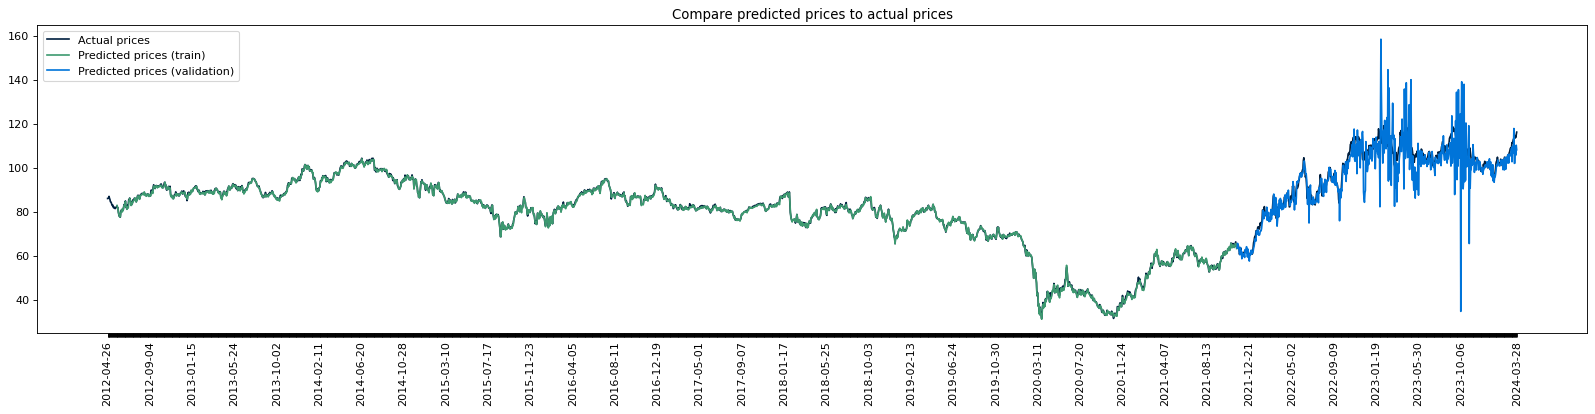

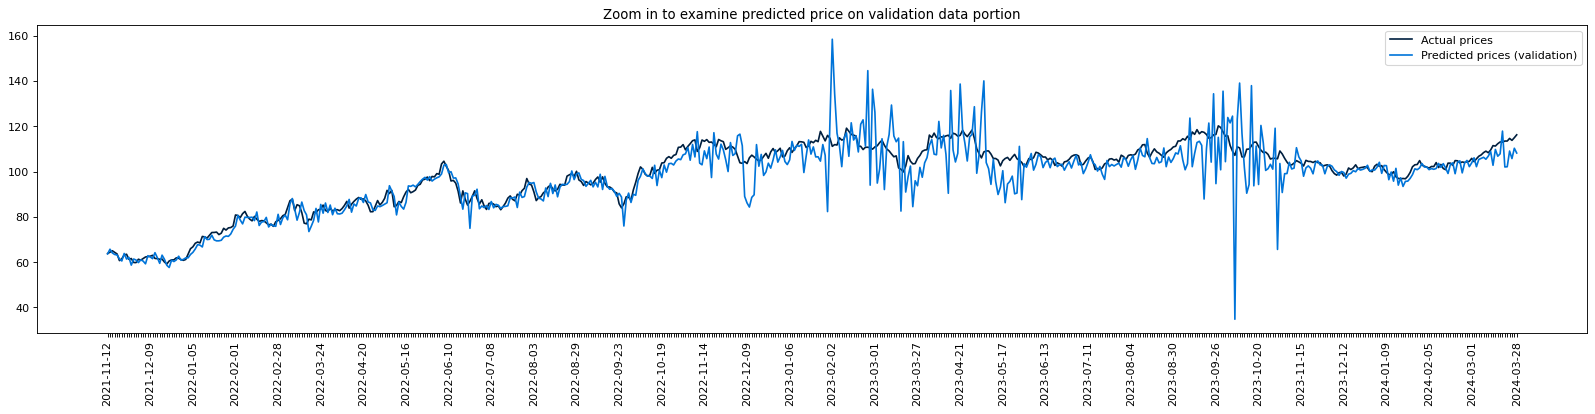

In [19]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))


# prepare data for plotting, show predicted prices

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = plt.figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.legend()
plt.show()

# prepare data for plotting, zoom in validation

to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = plt.figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.legend()
plt.show()

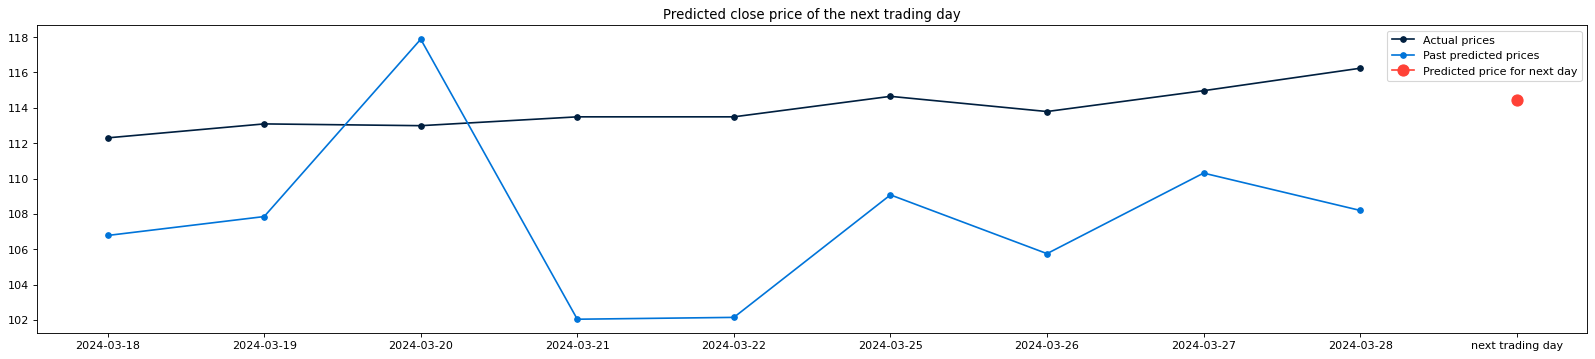

Predicted close price of the next trading day: 114.47


In [20]:
# predict on the unseen data, tomorrow's price 

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]
plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = prediction

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test.append("next trading day")

fig = plt.figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))

In [7]:
# Download historical data for a stock, e.g., Apple (AAPL)
data = ek.get_timeseries('NKE',
                        fields = '*', 
                        start_date = '2024-01-10',
                        end_date= '2024-8-10')

data = data.drop(columns=["COUNT"])

data = data.rename(columns={"HIGH": "High", "LOW": "Low", "OPEN": "Open", "VOLUME": "Volume", "CLOSE": "Close" })
data['Volume'] = data['Volume'].astype(int)
data

NKE,High,Close,Low,Open,Volume
Date,,,,,
2024-01-10,103.83,103.77,102.37,102.69,6784662
2024-01-11,106.01,105.9,103.73,104.22,9537701
2024-01-12,106.32,105.06,104.72,106.0,6680858
2024-01-16,104.2199,101.72,101.36,103.94,10547901
2024-01-17,101.31,100.82,100.24,101.05,8226243
...,...,...,...,...,...
2024-08-05,72.62,71.42,70.7502,71.06,13191528
2024-08-06,73.24,72.5,71.51,71.66,13469719
2024-08-07,74.2119,72.62,72.525,72.88,9571247


In [8]:
# Step 2: Define custom colors
custom_style = mpf.make_mpf_style(base_mpl_style='seaborn', marketcolors=mpf.make_marketcolors(
    up='green',  # Color for bullish candles
    down='red',  # Color for bearish candles
    wick={'up': 'green', 'down': 'red'},  # Wick colors
    edge={'up': 'green', 'down': 'red'}  # Border colors
),
                                 gridstyle = '',
    
                                 facecolor="white")


In [9]:
def download_resize_and_crop_images(input_folder, output_folder, target_size, crop_box, ticker_list):
    """
    Resize all images in the input folder to a target size, then crop them and save to the output folder.

    Parameters:
    - input_folder (str): Path to the folder containing the images.
    - output_folder (str): Path to the folder where resized and cropped images will be saved.
    - target_size (tuple): Target size (width, height) to resize images.
    - crop_box (tuple): A tuple (left, upper, right, lower) defining the cropping box.
    """
    # Download historical data for a stock, e.g., Apple (AAPL)
    for year in ['2023']:
        print(year)
        for i in range(len(ticker_list)):
            try:
                ticker= ticker_list[i]
                print(ticker, i)
                data = ek.get_timeseries(ticker,
                                        fields = '*', 
                                        start_date = str(year) + '-01-10',
                                        end_date= str(year) + '-8-10')

                data = data.drop(columns=["COUNT"])
                data = data.rename(columns={"HIGH": "High", "LOW": "Low", "OPEN": "Open", "VOLUME": "Volume", "CLOSE": "Close" })
                data['Volume'] = data['Volume'].astype(int)
                data['Open'] = data['Open'].astype(float)
                data['Low'] = data['Low'].astype(float)
                data['High'] = data['High'].astype(float)
                data['Close'] = data['Close'].astype(float)

                # save plot with custom colors
                mpf.plot(
                    data,
                    type='candle',
                    volume=False,
                    style=custom_style,
                    figsize=(8, 5),
                    savefig='charts/'+str(ticker)+'-' + str(year) +'.png'
                )
                
                gc.collect()  # Force garbage collection

            except Exception as e: continue


        # Loop over all files in the input folder
        for filename in os.listdir(input_folder):
            if filename.lower().endswith(('.png')):
                try:
                    # Open the image
                    img_path = os.path.join(input_folder, filename)
                    img = Image.open(img_path)

                    # Resize the image to the target size
                    img_resized = img.resize(target_size)

                    # Crop the image
                    cropped_img = img_resized.crop(crop_box)

                    # Save the cropped image
                    cropped_img_path = os.path.join(output_folder, filename)
                    cropped_img.save(cropped_img_path)
                    print(f"Resized and cropped image saved: {cropped_img_path}")

                except Exception as e:
                    print(f"Error processing {filename}: {e}")

In [10]:
# Get ticker names in Nasdaq Composite
df, err = ek.get_data('0#.IXIC','CF_NAME')
ticker_list = df.iloc[:, 0].tolist()

C:\Users\rebei\anaconda3\envs\forecast\lib\site-packages\eikon\data_grid.py:255: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [ ]:
input_folder = 'charts/'  # Replace with your folder path
output_folder = 'charts/'  # Replace with your output folder path
target_size = (800, 500)  # Resize all images to 800x800
crop_box = (150, 30, 710, 420)  # Define your cropping box (left, upper, right, lower)
download_resize_and_crop_images(input_folder, output_folder, target_size, crop_box, ticker_list)

2023
CJJD.OQ 0
MAMA.OQ 1
CLYM.OQ 2
TASK.OQ 3
FANG.OQ 4
PHAT.OQ 5
FRAF.OQ 6
QTRX.OQ 7
MKDW.OQ 8
TARS.OQ 9
NKSH.OQ 10
WGS.OQ 11
GDST.OQ 12
GOVX.OQ 13
HEPS.OQ 14
GOOD.OQ 15
SABR.OQ 16
INTG.OQ 17
MFH.OQ 18
AKRO.OQ 19
FMST.OQ 20


2024-11-17 20:58:06,546 P[142904] [MainThread 154244] Error with FMST.OQ: No data available for the requested date range
2024-11-17 20:58:06,546 P[142904] [MainThread 154244] FMST.OQ: No data available for the requested date range | 


SFM.OQ 21
BIVI.OQ 22
KC.OQ 23
GOOGL.OQ 24
DCTH.OQ 25
HOFT.OQ 26
FIP.OQ 27
RLMD.OQ 28


2024-11-17 20:58:12,023 P[142904] [MainThread 154244] Error with MBAV.OQ: No data available for the requested date range
2024-11-17 20:58:12,024 P[142904] [MainThread 154244] MBAV.OQ: No data available for the requested date range | 


MBAV.OQ 29
NOVT.OQ 30
VIVK.OQ 31
CLDX.OQ 32
WALD.OQ 33
RGNX.OQ 34
ONFO.OQ 35
CTXR.OQ 36
SKYW.OQ 37
DRTS.OQ 38
ZKIN.OQ 39
TPCS.OQ 40
RENE.OQ 41
EZFL.OQ 42
VRNT.OQ 43
SCLX.OQ 44
INVE.OQ 45
SSBI.OQ 46
INFN.OQ 47
TTWO.OQ 48
MNRO.OQ 49
FAT.OQ 50
UONE.OQ 51
STEP.OQ 52
HCKT.OQ 53
ICHR.OQ 54
BCG.OQ 55


2024-11-17 20:58:29,969 P[142904] [MainThread 154244] Error with BCG.OQ: No data available for the requested date range
2024-11-17 20:58:29,970 P[142904] [MainThread 154244] BCG.OQ: No data available for the requested date range | 


ARKO.OQ 56
MTLS.OQ 57
NTRP.OQ 58
ACIC.OQ 59
TTEK.OQ 60
TMTC.OQ 61
PLRZ.OQ 62


2024-11-17 20:58:33,924 P[142904] [MainThread 154244] Error with PLRZ.OQ: No data available for the requested date range
2024-11-17 20:58:33,925 P[142904] [MainThread 154244] PLRZ.OQ: No data available for the requested date range | 


DSGR.OQ 63
TMC.OQ 64
AIRE.OQ 65


2024-11-17 20:58:36,399 P[142904] [MainThread 154244] Error with AIRE.OQ: No data available for the requested date range
2024-11-17 20:58:36,400 P[142904] [MainThread 154244] AIRE.OQ: No data available for the requested date range | 


KITT.OQ 66
MEDP.OQ 67
OMAB.OQ 68
CRNT.OQ 69
BNRG.OQ 70
SGLY.OQ 71
EQ.OQ 72
BANR.OQ 73
SONM.OQ 74
QH.OQ 75
FAAS.OQ 76
NUKK.OQ 77
BFRI.OQ 78
IPWR.OQ 79
TIPT.OQ 80
IVCP.OQ 81
ALLK.OQ 82
AFRM.OQ 83
AMPL.OQ 84
IVCA.OQ 85
KZR.OQ 86
BELFA.OQ 87
STRL.OQ 88
INDI.OQ 89
INSM.OQ 90
PDSB.OQ 91
CYTH.OQ 92
EUDA.OQ 93
HEPA.OQ 94
CHCO.OQ 95
FTRE.OQ 96
ENTO.OQ 97
VISL.OQ 98
ISSC.OQ 99
FYBR.OQ 100
SCPH.OQ 101
CCCC.OQ 102
JAZZ.OQ 103
MBIO.OQ 104
CNSP.OQ 105
LOAN.OQ 106
ESGL.OQ 107
HNVR.OQ 108
TIVC.OQ 109
LWAY.OQ 110
TANH.OQ 111
MRVL.OQ 112
DDI.OQ 113
RBBN.OQ 114
SGRP.OQ 115


2024-11-17 20:59:09,446 P[142904] [MainThread 154244] Error with MGX.OQ: No data available for the requested date range
2024-11-17 20:59:09,447 P[142904] [MainThread 154244] MGX.OQ: No data available for the requested date range | 


MGX.OQ 116
VTVT.OQ 117
WSBC.OQ 118
CDTG.OQ 119


2024-11-17 20:59:11,207 P[142904] [MainThread 154244] Error with CDTG.OQ: No data available for the requested date range
2024-11-17 20:59:11,207 P[142904] [MainThread 154244] CDTG.OQ: No data available for the requested date range | 


ABEO.OQ 120
AMZN.OQ 121
TTD.OQ 122
WIX.OQ 123
JFU.OQ 124
LVTX.OQ 125
IBAC.OQ 126


2024-11-17 20:59:14,789 P[142904] [MainThread 154244] Error with IBAC.OQ: No data available for the requested date range
2024-11-17 20:59:14,790 P[142904] [MainThread 154244] IBAC.OQ: No data available for the requested date range | 


PCVX.OQ 127
ERAS.OQ 128
HAIN.OQ 129
BHAT.OQ 130


2024-11-17 20:59:17,157 P[142904] [MainThread 154244] Error with CUB.OQ: No data available for the requested date range
2024-11-17 20:59:17,158 P[142904] [MainThread 154244] CUB.OQ: No data available for the requested date range | 


CUB.OQ 131
OLPX.OQ 132
ELVN.OQ 133
INTJ.OQ 134


2024-11-17 20:59:18,884 P[142904] [MainThread 154244] Error with INTJ.OQ: No data available for the requested date range
2024-11-17 20:59:18,885 P[142904] [MainThread 154244] INTJ.OQ: No data available for the requested date range | 


CNET.OQ 135
LDTC.OQ 136
SANG.OQ 137
WMPN.OQ 138
NSTS.OQ 139
PHUN.OQ 140
ULTA.OQ 141
ILMN.OQ 142
OPEN.OQ 143
BYND.OQ 144
GWAV.OQ 145
MTCH.OQ 146
ACOG.OQ 147


2024-11-17 20:59:28,769 P[142904] [MainThread 154244] Error with ACOG.OQ: No data available for the requested date range
2024-11-17 20:59:28,770 P[142904] [MainThread 154244] ACOG.OQ: No data available for the requested date range | 


OCX.OQ 148
HCM.OQ 149
CLBT.OQ 150
SBCF.OQ 151
NTWK.OQ 152
SKWD.OQ 153
QNST.OQ 154
CLBK.OQ 155
FRBA.OQ 156
CADL.OQ 157
RECT.OQ 158


2024-11-17 20:59:35,329 P[142904] [MainThread 154244] Error with RECT.OQ: No data available for the requested date range
2024-11-17 20:59:35,330 P[142904] [MainThread 154244] RECT.OQ: No data available for the requested date range | 


GCT.OQ 159
RMCF.OQ 160
RENT.OQ 161
HOOK.OQ 162
AMST.OQ 163


2024-11-17 20:59:39,403 P[142904] [MainThread 154244] Error with SOWG.OQ: No data available for the requested date range
2024-11-17 20:59:39,403 P[142904] [MainThread 154244] SOWG.OQ: No data available for the requested date range | 


SOWG.OQ 164
VSAT.OQ 165
KXIN.OQ 166
VCYT.OQ 167
VRME.OQ 168
UNTY.OQ 169
PEV.OQ 170
MESA.OQ 171
PDLB.OQ 172
EHGO.OQ 173


2024-11-17 20:59:44,679 P[142904] [MainThread 154244] Error with EHGO.OQ: No data available for the requested date range
2024-11-17 20:59:44,679 P[142904] [MainThread 154244] EHGO.OQ: No data available for the requested date range | 


NBTX.OQ 174
SPHL.OQ 175


2024-11-17 20:59:45,635 P[142904] [MainThread 154244] Error with SPHL.OQ: No data available for the requested date range
2024-11-17 20:59:45,635 P[142904] [MainThread 154244] SPHL.OQ: No data available for the requested date range | 


BNTX.OQ 176
MIST.OQ 177
GLXG.OQ 178


2024-11-17 20:59:47,249 P[142904] [MainThread 154244] Error with GLXG.OQ: No data available for the requested date range
2024-11-17 20:59:47,250 P[142904] [MainThread 154244] GLXG.OQ: No data available for the requested date range | 


LIDR.OQ 179
SENEA.OQ 180
DRIO.OQ 181
CPB.OQ 182


2024-11-17 20:59:49,585 P[142904] [MainThread 154244] Error with CPBI.OQ: No data available for the requested date range
2024-11-17 20:59:49,586 P[142904] [MainThread 154244] CPBI.OQ: No data available for the requested date range | 


CPBI.OQ 183
MNST.OQ 184
IBCP.OQ 185
WDFC.OQ 186
JYD.OQ 187
CVRX.OQ 188
INMD.OQ 189
APP.OQ 190
GEHC.OQ 191
PGNY.OQ 192
AVPT.OQ 193
SCKT.OQ 194
TEAM.OQ 195
BZ.OQ 196
GSIW.OQ 197


2024-11-17 20:59:59,338 P[142904] [MainThread 154244] Error with GSIW.OQ: No data available for the requested date range
2024-11-17 20:59:59,338 P[142904] [MainThread 154244] GSIW.OQ: No data available for the requested date range | 


TOMZ.OQ 198
SXTP.OQ 199
LITM.OQ 200
IART.OQ 201
PFG.OQ 202
WPRT.OQ 203
COYA.OQ 204
SNFCA.OQ 205
NITO.OQ 206
ASPS.OQ 207
EFSC.OQ 208
SDGR.OQ 209
KINS.OQ 210
PCB.OQ 211
HSPO.OQ 212


2024-11-17 21:00:08,068 P[142904] [MainThread 154244] Error with HSPO.OQ: No data available for the requested date range
2024-11-17 21:00:08,069 P[142904] [MainThread 154244] HSPO.OQ: No data available for the requested date range | 


OCS.OQ 213
CCEP.OQ 214
FROG.OQ 215
CATY.OQ 216
NEXN.OQ 217
AVNW.OQ 218
DGHI.OQ 219
VINO.OQ 220
HRMY.OQ 221
BWIN.OQ 222
TOP.OQ 223
APM.OQ 224
PLMJ.OQ 225
AHG.OQ 226
SLDP.OQ 227
ALTO.OQ 228
FAST.OQ 229
MRUS.OQ 230
LFCR.OQ 231
RBCAA.OQ 232
CPTN.OQ 233
SKYQ.OQ 234


2024-11-17 21:00:19,382 P[142904] [MainThread 154244] Error with SKYQ.OQ: No data available for the requested date range
2024-11-17 21:00:19,383 P[142904] [MainThread 154244] SKYQ.OQ: No data available for the requested date range | 


NCNO.OQ 235
SNCY.OQ 236
TLPH.OQ 237
RXST.OQ 238
INTU.OQ 239
FXNC.OQ 240
THAR.OQ 241
UGRO.OQ 242
RSLS.OQ 243
PARA.OQ 244
COMM.OQ 245
ACAD.OQ 246
ATRC.OQ 247
CRNC.OQ 248
BCML.OQ 249
STBA.OQ 250


2024-11-17 21:00:29,628 P[142904] [MainThread 154244] Error with RFAI.OQ: No data available for the requested date range
2024-11-17 21:00:29,629 P[142904] [MainThread 154244] RFAI.OQ: No data available for the requested date range | 


RFAI.OQ 251
HOLX.OQ 252
MCHP.OQ 253
PROC.OQ 254
BCTX.OQ 255
ALNT.OQ 256
HSAI.OQ 257
VEEE.OQ 258
VERB.OQ 259
RUN.OQ 260
UBCP.OQ 261
XENE.OQ 262
OCTO.OQ 263
EGHT.OQ 264
XOS.OQ 265
CRMT.OQ 266
TVTX.OQ 267
LIFW.OQ 268
RGS.OQ 269
NDRA.OQ 270
YMAB.OQ 271
LIVN.OQ 272
MNTK.OQ 273
IVDA.OQ 274


2024-11-17 21:00:42,950 P[142904] [MainThread 154244] Error with SEPN.OQ: No data available for the requested date range
2024-11-17 21:00:42,951 P[142904] [MainThread 154244] SEPN.OQ: No data available for the requested date range | 


SEPN.OQ 275
MMV.OQ 276
BMEA.OQ 277
EDBL.OQ 278
CMPX.OQ 279
CRTO.OQ 280
BECN.OQ 281
ZNTL.OQ 282
NOTV.OQ 283
NWS.OQ 284
SMTC.OQ 285
ERIC.OQ 286
MPB.OQ 287
BRZE.OQ 288
FVN.OQ 289


2024-11-17 21:00:51,179 P[142904] [MainThread 154244] Error with FVN.OQ: No data available for the requested date range
2024-11-17 21:00:51,180 P[142904] [MainThread 154244] FVN.OQ: No data available for the requested date range | 


AURA.OQ 290
CWCO.OQ 291
TOYO.OQ 292
WILC.OQ 293
BANL.OQ 294
KELYB.OQ 295
ACRV.OQ 296
HOVR.OQ 297
SEED.OQ 298
CCTG.OQ 299


2024-11-17 21:00:57,125 P[142904] [MainThread 154244] Error with CCTG.OQ: No data available for the requested date range
2024-11-17 21:00:57,126 P[142904] [MainThread 154244] CCTG.OQ: No data available for the requested date range | 


IPSC.OQ 300
ACHC.OQ 301
GDHG.OQ 302
PSNL.OQ 303
HURA.OQ 304
FVCB.OQ 305
RPID.OQ 306
CBAT.OQ 307
EMKR.OQ 308
ROOT.OQ 309
LEXX.OQ 310
TCBP.OQ 311
IMOS.OQ 312
EDIT.OQ 313
SANW.OQ 314
EDRY.OQ 315
STKH.OQ 316
ADP.OQ 317
TKLF.OQ 318
LSB.OQ 319
SPGC.OQ 320


2024-11-17 21:01:15,893 P[142904] [MainThread 154244] Error with SPGC.OQ: No data available for the requested date range
2024-11-17 21:01:15,894 P[142904] [MainThread 154244] SPGC.OQ: No data available for the requested date range | 


PERI.OQ 321
JRSH.OQ 322
HUBG.OQ 323
ASLE.OQ 324
VIOT.OQ 325
DGICA.OQ 326
SMSI.OQ 327
SPT.OQ 328
GLRE.OQ 329
QNRX.OQ 330
CHRS.OQ 331
SJW.OQ 332
CLNN.OQ 333
DCGO.OQ 334
SNCR.OQ 335
CBSH.OQ 336
SDOT.OQ 337
OCUL.OQ 338
FCBC.OQ 339
XELB.OQ 340
LMB.OQ 341
PCT.OQ 342
HLMN.OQ 343
BFRG.OQ 344
FSUN.OQ 345


2024-11-17 21:01:33,804 P[142904] [MainThread 154244] Error with FSUN.OQ: No data available for the requested date range
2024-11-17 21:01:33,804 P[142904] [MainThread 154244] FSUN.OQ: No data available for the requested date range | 


RPRX.OQ 346
POWW.OQ 347
REAL.OQ 348
MODD.OQ 349
BEAT.OQ 350
ALGT.OQ 351
BAYA.OQ 352


2024-11-17 21:01:38,235 P[142904] [MainThread 154244] Error with BAYA.OQ: No data available for the requested date range
2024-11-17 21:01:38,237 P[142904] [MainThread 154244] BAYA.OQ: No data available for the requested date range | 


SPWH.OQ 353
SNTG.OQ 354
BVS.OQ 355
KARO.OQ 356
BGFV.OQ 357
SEVN.OQ 358
LPSN.OQ 359
ELUT.OQ 360
ONCO.OQ 361
YOSH.OQ 362
NISN.OQ 363
GRAB.OQ 364
CNTB.OQ 365
ARQ.OQ 366
CCB.OQ 367
TMDX.OQ 368
DFLI.OQ 369
PPBT.OQ 370
NTLA.OQ 371
SSRM.OQ 372
VITL.OQ 373
MITA.OQ 374


2024-11-17 21:01:52,742 P[142904] [MainThread 154244] Error with MRX.OQ: No data available for the requested date range
2024-11-17 21:01:52,743 P[142904] [MainThread 154244] MRX.OQ: No data available for the requested date range | 


MRX.OQ 375
ACMR.OQ 376
AKAM.OQ 377
KLAC.OQ 378
LIND.OQ 379
GSHD.OQ 380
SUPN.OQ 381
CRGX.OQ 382


2024-11-17 21:01:56,048 P[142904] [MainThread 154244] Error with CRGX.OQ: No data available for the requested date range
2024-11-17 21:01:56,048 P[142904] [MainThread 154244] CRGX.OQ: No data available for the requested date range | 


AAME.OQ 383
SNTI.OQ 384
NCRA.OQ 385
TRDA.OQ 386
III.OQ 387
YOTA.OQ 388
IAC.OQ 389
PRPO.OQ 390
ARAY.OQ 391
TROW.OQ 392
GAMB.OQ 393
OAKU.OQ 394
VC.OQ 395
CZWI.OQ 396
ECPG.OQ 397
RMR.OQ 398
BNOX.OQ 399
NOVV.OQ 400
RPAY.OQ 401
STRS.OQ 402
ACTG.OQ 403
WFCF.OQ 404
MGNX.OQ 405
NVTS.OQ 406
GAIA.OQ 407
LFLY.OQ 408
TBLA.OQ 409
MAPS.OQ 410
WTMA.OQ 411
SNRE.OQ 412


2024-11-17 21:02:14,712 P[142904] [MainThread 154244] Error with SNRE.OQ: No data available for the requested date range
2024-11-17 21:02:14,713 P[142904] [MainThread 154244] SNRE.OQ: No data available for the requested date range | 


OPTN.OQ 413
MEOH.OQ 414
AIFF.OQ 415
TATT.OQ 416
BGC.OQ 417
CRAI.OQ 418
FARO.OQ 419
OSW.OQ 420
BREA.OQ 421
PIII.OQ 422
EVOK.OQ 423
SLAB.OQ 424
FIZZ.OQ 425
EDUC.OQ 426
LVO.OQ 427
PLXS.OQ 428
FTII.OQ 429


2024-11-17 21:02:25,415 P[142904] [MainThread 154244] Error with EURK.OQ: No data available for the requested date range
2024-11-17 21:02:25,416 P[142904] [MainThread 154244] EURK.OQ: No data available for the requested date range | 


EURK.OQ 430
VERI.OQ 431
FLGC.OQ 432
EBTC.OQ 433
INCY.OQ 434
SIBN.OQ 435
PWOD.OQ 436
CBNK.OQ 437
ATPC.OQ 438


2024-11-17 21:02:29,921 P[142904] [MainThread 154244] Error with ATPC.OQ: No data available for the requested date range
2024-11-17 21:02:29,922 P[142904] [MainThread 154244] ATPC.OQ: No data available for the requested date range | 


NXT.OQ 439
COKE.OQ 440
UONEK.OQ 441
SIGI.OQ 442
TLRY.OQ 443
HQY.OQ 444
BBCP.OQ 445
DCBO.OQ 446
COO.OQ 447
GAME.OQ 448
MBX.OQ 449


2024-11-17 21:02:35,592 P[142904] [MainThread 154244] Error with MBX.OQ: No data available for the requested date range
2024-11-17 21:02:35,593 P[142904] [MainThread 154244] MBX.OQ: No data available for the requested date range | 


PYXS.OQ 450
PFIE.OQ 451
GPRE.OQ 452
CECO.OQ 453
JZXN.OQ 454


2024-11-17 21:02:39,322 P[142904] [MainThread 154244] Error with DTSQ.OQ: No data available for the requested date range
2024-11-17 21:02:39,323 P[142904] [MainThread 154244] DTSQ.OQ: No data available for the requested date range | 


DTSQ.OQ 455
LYRA.OQ 456
THRM.OQ 457
FINW.OQ 458
MANH.OQ 459
QNCX.OQ 460
CALC.OQ 461
CINF.OQ 462
NRDS.OQ 463
ESLT.OQ 464
ICON.OQ 465


2024-11-17 21:02:46,206 P[142904] [MainThread 154244] Error with ICON.OQ: No data available for the requested date range
2024-11-17 21:02:46,207 P[142904] [MainThread 154244] ICON.OQ: No data available for the requested date range | 


SYRA.OQ 466


2024-11-17 21:02:46,727 P[142904] [MainThread 154244] Error with SYRA.OQ: No data available for the requested date range
2024-11-17 21:02:46,728 P[142904] [MainThread 154244] SYRA.OQ: No data available for the requested date range | 


VVOS.OQ 467
WTFC.OQ 468
ACLS.OQ 469
CARM.OQ 470
CMBM.OQ 471
GREE.OQ 472
TWG.OQ 473


2024-11-17 21:02:50,896 P[142904] [MainThread 154244] Error with TWG.OQ: No data available for the requested date range
2024-11-17 21:02:50,897 P[142904] [MainThread 154244] TWG.OQ: No data available for the requested date range | 


CMMB.OQ 474
PWUP.OQ 475
BITF.OQ 476
POAI.OQ 477
FKWL.OQ 478
OB.OQ 479
LEGN.OQ 480
CMAX.OQ 481
FSHP.OQ 482


2024-11-17 21:02:56,918 P[142904] [MainThread 154244] Error with FSHP.OQ: No data available for the requested date range
2024-11-17 21:02:56,919 P[142904] [MainThread 154244] FSHP.OQ: No data available for the requested date range | 


CING.OQ 483
CHRD.OQ 484
QUIK.OQ 485
KOD.OQ 486
ARQT.OQ 487
EDAP.OQ 488
PFIS.OQ 489
IMG.OQ 490
NVEI.OQ 491


2024-11-17 21:03:02,007 P[142904] [MainThread 154244] Error with NVEI.OQ: Invalid RIC
2024-11-17 21:03:02,007 P[142904] [MainThread 154244] NVEI.OQ: Invalid RIC | 


CRGO.OQ 492
PLCE.OQ 493
REAX.OQ 494
IRBT.OQ 495
VRRM.OQ 496
AY.OQ 497
EU.OQ 498
NSPR.OQ 499
BLBD.OQ 500
LSCC.OQ 501
GLSI.OQ 502
GRPN.OQ 503
JOUT.OQ 504
EVO.OQ 505
DYAI.OQ 506
LLYVK.OQ 507
RDHL.OQ 508
CRNX.OQ 509
VERO.OQ 510
BWEN.OQ 511
IPW.OQ 512
MOLN.OQ 513
WAVS.OQ 514
PTPI.OQ 515
EXPO.OQ 516
FSLR.OQ 517
LKFN.OQ 518
LOGC.OQ 519
TRML.OQ 520
ILPT.OQ 521
VERA.OQ 522
QOMO.OQ 523
FOX.OQ 524
RAPT.OQ 525
HTOO.OQ 526
ESCA.OQ 527
WOK.OQ 528


2024-11-17 21:03:22,798 P[142904] [MainThread 154244] Error with WOK.OQ: No data available for the requested date range
2024-11-17 21:03:22,799 P[142904] [MainThread 154244] WOK.OQ: No data available for the requested date range | 


PAMT.OQ 529
SYRE.OQ 530
HPAI.OQ 531
CLPS.OQ 532
BIIB.OQ 533
ENTX.OQ 534
HYPR.OQ 535
ADTN.OQ 536
ABL.OQ 537
SWIN.OQ 538


2024-11-17 21:03:27,990 P[142904] [MainThread 154244] Error with SWIN.OQ: No data available for the requested date range
2024-11-17 21:03:27,991 P[142904] [MainThread 154244] SWIN.OQ: No data available for the requested date range | 


NLSP.OQ 539
BTMD.OQ 540
MLKN.OQ 541
STLD.OQ 542
HYZN.OQ 543
VABK.OQ 544
ARCT.OQ 545
OPK.OQ 546
OVBC.OQ 547
AACG.OQ 548
EXE.OQ 549
PROP.OQ 550


2024-11-17 21:03:34,045 P[142904] [MainThread 154244] Error with PROP.OQ: No data available for the requested date range
2024-11-17 21:03:34,046 P[142904] [MainThread 154244] PROP.OQ: No data available for the requested date range | 


MSS.OQ 551


2024-11-17 21:03:34,431 P[142904] [MainThread 154244] Error with MSS.OQ: No data available for the requested date range
2024-11-17 21:03:34,432 P[142904] [MainThread 154244] MSS.OQ: No data available for the requested date range | 


RDZN.OQ 552
IBRX.OQ 553
HTLM.OQ 554


2024-11-17 21:03:36,257 P[142904] [MainThread 154244] Error with HTLM.OQ: No data available for the requested date range
2024-11-17 21:03:36,257 P[142904] [MainThread 154244] HTLM.OQ: No data available for the requested date range | 


QUBT.OQ 555
TCBK.OQ 556
DLTH.OQ 557
EMCG.OQ 558
META.OQ 559
PCAR.OQ 560
SHIM.OQ 561


2024-11-17 21:03:40,150 P[142904] [MainThread 154244] Error with SHIM.OQ: No data available for the requested date range
2024-11-17 21:03:40,151 P[142904] [MainThread 154244] SHIM.OQ: No data available for the requested date range | 


SLNG.OQ 562
RZLV.OQ 563
LPCN.OQ 564
DMAC.OQ 565
NRIX.OQ 566
RBB.OQ 567
ADI.OQ 568
FFIE.OQ 569
SOPA.OQ 570
QLGN.OQ 571
WYNN.OQ 572
UTMD.OQ 573
RVMD.OQ 574
TAIT.OQ 575
TLGY.OQ 576
EQIX.OQ 577
TIGO.OQ 578
CSCI.OQ 579


2024-11-17 21:03:52,474 P[142904] [MainThread 154244] Error with ANL.OQ: No data available for the requested date range
2024-11-17 21:03:52,475 P[142904] [MainThread 154244] ANL.OQ: No data available for the requested date range | 


ANL.OQ 580
EVRG.OQ 581
JNVR.OQ 582
ASTS.OQ 583
UEIC.OQ 584
INBK.OQ 585
BACK.OQ 586
PWM.OQ 587
FRPH.OQ 588
APPS.OQ 589
ABP.OQ 590
APPF.OQ 591


2024-11-17 21:03:58,401 P[142904] [MainThread 154244] Error with OS.OQ: No data available for the requested date range
2024-11-17 21:03:58,402 P[142904] [MainThread 154244] OS.OQ: No data available for the requested date range | 


OS.OQ 592
AMIX.OQ 593


2024-11-17 21:03:58,583 P[142904] [MainThread 154244] Error with AMIX.OQ: No data available for the requested date range
2024-11-17 21:03:58,583 P[142904] [MainThread 154244] AMIX.OQ: No data available for the requested date range | 


LOGI.OQ 594
WCT.OQ 595


2024-11-17 21:03:59,661 P[142904] [MainThread 154244] Error with WCT.OQ: No data available for the requested date range
2024-11-17 21:03:59,661 P[142904] [MainThread 154244] WCT.OQ: No data available for the requested date range | 


VKTX.OQ 596
CMCT.OQ 597
STIM.OQ 598
PLL.OQ 599
KOPN.OQ 600
TBBK.OQ 601


2024-11-17 21:04:03,615 P[142904] [MainThread 154244] Error with GRAL.OQ: No data available for the requested date range
2024-11-17 21:04:03,615 P[142904] [MainThread 154244] GRAL.OQ: No data available for the requested date range | 


GRAL.OQ 602
ATRA.OQ 603
BRAC.OQ 604
SPOK.OQ 605
APRE.OQ 606
COCO.OQ 607
ZYXI.OQ 608
KIDS.OQ 609
KURA.OQ 610
MOGO.OQ 611
KRNT.OQ 612
EEFT.OQ 613
SILC.OQ 614
TCRX.OQ 615
CARG.OQ 616
FTFT.OQ 617
HOOD.OQ 618
IMNN.OQ 619
GRRR.OQ 620
INAQ.OQ 621
CDIO.OQ 622


2024-11-17 21:04:14,245 P[142904] [MainThread 154244] Error with LRE.OQ: No data available for the requested date range
2024-11-17 21:04:14,245 P[142904] [MainThread 154244] LRE.OQ: No data available for the requested date range | 


LRE.OQ 623
NVAC.OQ 624
NVVE.OQ 625
CLRO.OQ 626
PXDT.OQ 627
VRPX.OQ 628
AWH.OQ 629
WTW.OQ 630
RMBS.OQ 631
VNOM.OQ 632
SCWX.OQ 633
PSNY.OQ 634
JAMF.OQ 635
GTEC.OQ 636
AIXI.OQ 637
NUWE.OQ 638
TCOM.OQ 639
GNPX.OQ 640
CSCO.OQ 641
CPRX.OQ 642
SOHU.OQ 643
VGAS.OQ 644
HON.OQ 645
AYTU.OQ 646


2024-11-17 21:04:27,839 P[142904] [MainThread 154244] Error with AZI.OQ: No data available for the requested date range


AZI.OQ 647


2024-11-17 21:04:27,840 P[142904] [MainThread 154244] AZI.OQ: No data available for the requested date range | 


BYU.OQ 648
DORM.OQ 649
KRRO.OQ 650
ANTX.OQ 651
DMLP.OQ 652
XXII.OQ 653
EBAY.OQ 654
PROK.OQ 655
NA.OQ 656
RSSS.OQ 657
BBIO.OQ 658
TXMD.OQ 659
AWRE.OQ 660
LINE.OQ 661


2024-11-17 21:04:35,578 P[142904] [MainThread 154244] Error with LINE.OQ: No data available for the requested date range
2024-11-17 21:04:35,578 P[142904] [MainThread 154244] LINE.OQ: No data available for the requested date range | 


VIRC.OQ 662
AIRS.OQ 663
OPXS.OQ 664
ECBK.OQ 665
AREC.OQ 666
RETO.OQ 667
RIGL.OQ 668
CCSI.OQ 669
AAL.OQ 670
DADA.OQ 671
AIMD.OQ 672
NICE.OQ 673
WNEB.OQ 674
NKLA.OQ 675
PCSC.OQ 676


2024-11-17 21:04:43,915 P[142904] [MainThread 154244] Error with PCSC.OQ: No data available for the requested date range
2024-11-17 21:04:43,917 P[142904] [MainThread 154244] PCSC.OQ: No data available for the requested date range | 


BJRI.OQ 677
PT.OQ 678
ULBI.OQ 679
NAYA.OQ 680
TTEC.OQ 681
CCNE.OQ 682
INTS.OQ 683
HAYN.OQ 684
ORKT.OQ 685


2024-11-17 21:04:48,482 P[142904] [MainThread 154244] Error with ORKT.OQ: No data available for the requested date range
2024-11-17 21:04:48,483 P[142904] [MainThread 154244] ORKT.OQ: No data available for the requested date range | 


LGO.OQ 686
VOR.OQ 687
SRCE.OQ 688


2024-11-17 21:04:50,320 P[142904] [MainThread 154244] Error with SUGP.OQ: No data available for the requested date range
2024-11-17 21:04:50,321 P[142904] [MainThread 154244] SUGP.OQ: No data available for the requested date range | 


SUGP.OQ 689
HWBK.OQ 690
APLS.OQ 691
SIEB.OQ 692
LION.OQ 693
PTLE.OQ 694


2024-11-17 21:04:53,093 P[142904] [MainThread 154244] Error with PTLE.OQ: No data available for the requested date range
2024-11-17 21:04:53,093 P[142904] [MainThread 154244] PTLE.OQ: No data available for the requested date range | 


MESO.OQ 695
SCOR.OQ 696
ENLV.OQ 697
HLVX.OQ 698
TWIN.OQ 699
OPRT.OQ 700
ADUS.OQ 701
FUFU.OQ 702
TELA.OQ 703
HTLD.OQ 704
CERS.OQ 705
LGCB.OQ 706


2024-11-17 21:05:00,011 P[142904] [MainThread 154244] Error with LGCB.OQ: No data available for the requested date range
2024-11-17 21:05:00,012 P[142904] [MainThread 154244] LGCB.OQ: No data available for the requested date range | 


TETE.OQ 707
DARE.OQ 708
LVLU.OQ 709
NURO.OQ 710
ACON.OQ 711
KYTX.OQ 712


2024-11-17 21:05:03,191 P[142904] [MainThread 154244] Error with KYTX.OQ: No data available for the requested date range
2024-11-17 21:05:03,192 P[142904] [MainThread 154244] KYTX.OQ: No data available for the requested date range | 


BRNS.OQ 713
VOXX.OQ 714
WINV.OQ 715
PAYX.OQ 716
CMPR.OQ 717
YIBO.OQ 718


2024-11-17 21:05:06,775 P[142904] [MainThread 154244] Error with YIBO.OQ: No data available for the requested date range
2024-11-17 21:05:06,775 P[142904] [MainThread 154244] YIBO.OQ: No data available for the requested date range | 


EXAI.OQ 719
PUBM.OQ 720
BSVN.OQ 721
CRML.OQ 722
ASRT.OQ 723
ZBIO.OQ 724


2024-11-17 21:05:11,336 P[142904] [MainThread 154244] Error with ZBIO.OQ: No data available for the requested date range
2024-11-17 21:05:11,337 P[142904] [MainThread 154244] ZBIO.OQ: No data available for the requested date range | 


ICAD.OQ 725
MGEE.OQ 726
BRID.OQ 727
FLNC.OQ 728
AYRO.OQ 729
SMX.OQ 730
MNPR.OQ 731
LIQT.OQ 732
SEER.OQ 733
MCVT.OQ 734
LSTA.OQ 735
HALO.OQ 736
FONR.OQ 737
KALV.OQ 738
INBS.OQ 739
WISA.OQ 740
BNGO.OQ 741
YI.OQ 742
FBLA.OQ 743


2024-11-17 21:05:23,101 P[142904] [MainThread 154244] Error with FBLA.OQ: No data available for the requested date range
2024-11-17 21:05:23,102 P[142904] [MainThread 154244] FBLA.OQ: No data available for the requested date range | 


NRC.OQ 744
MEGL.OQ 745
ICCT.OQ 746
SBT.OQ 747
MOBX.OQ 748
BHF.OQ 749
WIMI.OQ 750
MYGN.OQ 751
LEGH.OQ 752
FFIN.OQ 753
TARA.OQ 754
LQR.OQ 755
FORTY.OQ 756
BJDX.OQ 757
USEG.OQ 758
NVCT.OQ 759
OCC.OQ 760
FFIV.OQ 761
LBRDK.OQ 762
XTKG.OQ 763
SBRA.OQ 764
PDYN.OQ 765
HNNA.OQ 766


2024-11-17 21:05:38,232 P[142904] [MainThread 154244] Error with MURA.OQ: No data available for the requested date range
2024-11-17 21:05:38,232 P[142904] [MainThread 154244] MURA.OQ: No data available for the requested date range | 


MURA.OQ 767
TBPH.OQ 768
VLGEA.OQ 769
NMIH.OQ 770
PHVS.OQ 771
OLED.OQ 772
VCTR.OQ 773
CARA.OQ 774
SMPL.OQ 775
ODD.OQ 776
ARHS.OQ 777
EH.OQ 778
AIHS.OQ 779
ARQQ.OQ 780
CZR.OQ 781
VRNS.OQ 782
LXEO.OQ 783


2024-11-17 21:05:49,192 P[142904] [MainThread 154244] Error with LXEO.OQ: No data available for the requested date range
2024-11-17 21:05:49,193 P[142904] [MainThread 154244] LXEO.OQ: No data available for the requested date range | 


KYMR.OQ 784
GRCE.OQ 785
XBP.OQ 786
RDNT.OQ 787
ROIV.OQ 788
CBRG.OQ 789
WEST.OQ 790
LPLA.OQ 791


2024-11-17 21:05:53,644 P[142904] [MainThread 154244] Error with GLAC.OQ: No data available for the requested date range
2024-11-17 21:05:53,644 P[142904] [MainThread 154244] GLAC.OQ: No data available for the requested date range | 


GLAC.OQ 792
IGTA.OQ 793
NWBI.OQ 794
CDZI.OQ 795
ARVN.OQ 796
WINT.OQ 797
CSLR.OQ 798
NVCR.OQ 799
SGHT.OQ 800
LUNG.OQ 801
TGL.OQ 802
HUDI.OQ 803
PGHL.OQ 804


2024-11-17 21:06:00,448 P[142904] [MainThread 154244] Error with PGHL.OQ: No data available for the requested date range
2024-11-17 21:06:00,449 P[142904] [MainThread 154244] PGHL.OQ: No data available for the requested date range | 


EDTK.OQ 805
PNRG.OQ 806
CNTX.OQ 807
APGE.OQ 808
PODD.OQ 809
NCPL.OQ 810
SVA.OQ 811


2024-11-17 21:06:03,906 P[142904] [MainThread 154244] Error with SVA.OQ: No data available for the requested date range
2024-11-17 21:06:03,907 P[142904] [MainThread 154244] SVA.OQ: No data available for the requested date range | 


AOSL.OQ 812
ZBRA.OQ 813
NSSC.OQ 814
BTAI.OQ 815
MGRM.OQ 816
AUID.OQ 817
SAVA.OQ 818
AFYA.OQ 819
GNTX.OQ 820
CMPO.OQ 821
VEEA.OQ 822
FBYD.OQ 823
AKTX.OQ 824
WING.OQ 825
SOPH.OQ 826
AXON.OQ 827
PEGA.OQ 828
SGMA.OQ 829
SIDU.OQ 830
TZUP.OQ 831


2024-11-17 21:06:17,095 P[142904] [MainThread 154244] Error with TZUP.OQ: No data available for the requested date range
2024-11-17 21:06:17,096 P[142904] [MainThread 154244] TZUP.OQ: No data available for the requested date range | 


ACNB.OQ 832
MDCX.OQ 833


2024-11-17 21:06:17,986 P[142904] [MainThread 154244] Error with MDCX.OQ: No data available for the requested date range
2024-11-17 21:06:17,987 P[142904] [MainThread 154244] MDCX.OQ: No data available for the requested date range | 


STAF.OQ 834
BOKF.OQ 835
OM.OQ 836
BTDR.OQ 837
OMGA.OQ 838
OMIC.OQ 839
ALLR.OQ 840
RDWR.OQ 841
INDV.OQ 842
GFAI.OQ 843
TOUR.OQ 844
POET.OQ 845
RELL.OQ 846
RGLD.OQ 847
ANEB.OQ 848
MDRR.OQ 849
FCCO.OQ 850
IBG.OQ 851


2024-11-17 21:06:31,447 P[142904] [MainThread 154244] Error with IBG.OQ: No data available for the requested date range
2024-11-17 21:06:31,448 P[142904] [MainThread 154244] IBG.OQ: No data available for the requested date range | 


NEGG.OQ 852
IRDM.OQ 853
WBA.OQ 854
PMCB.OQ 855
PMN.OQ 856
OTLK.OQ 857
ESOA.OQ 858
RPTX.OQ 859
BMRC.OQ 860
HAIA.OQ 861
MGIC.OQ 862
STI.OQ 863
KVHI.OQ 864
BNTC.OQ 865
MYRG.OQ 866
CAPR.OQ 867
GP.OQ 868
CNTM.OQ 869
BHRB.OQ 870
GATE.OQ 871
CREX.OQ 872
ACET.OQ 873
TTGT.OQ 874
SNAX.OQ 875
MRKR.OQ 876
SGMO.OQ 877
EXLS.OQ 878
USGO.OQ 879
STKL.OQ 880
